# Transformed Estimators

Whenever $x$ and $y$ are continuous and high-dimensional, estimating mutual information may require considerable resources.
Using the Data Processing Inequality (DPI), we can define a lower bound of mutual information by applying functions $f_x$ and $f_y$ to $x$ and $y$ respectively:
$$
I(x;y) \ge \max_{f_y \in \mathcal{F}_y} I(x;f_y(y)) \ge \max_{f_x\in \mathcal{F}_x, f_y \in \mathcal{F}_y} I(f_x(x);f_y(y))
$$

The functions $f_x$ and $f_y$ can be modeled via parametric neural network architectures which map structured high-dimensional data into lower-dimensional vector representations.



Here we will consider a simple example in which we will try to estimate mutual information between MNIST digits sampled from the same class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST


class PairedMNIST(Dataset):    
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.mnist = MNIST(*args, **kwargs)
        
    
    def __getitem__(self, idx):
        x, target = self.mnist[idx]
        idx_2 = np.random.choice(np.arange(len(dataset))[self.mnist.targets==target])
        y, target_2 = self.mnist[idx_2]
        assert target == target_2
        
        return {'x': x, 'y':y}
        
    def __len__(self):
        return self.mnist.__len__()
        
dataset = PairedMNIST('/data', transform=ToTensor())


/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


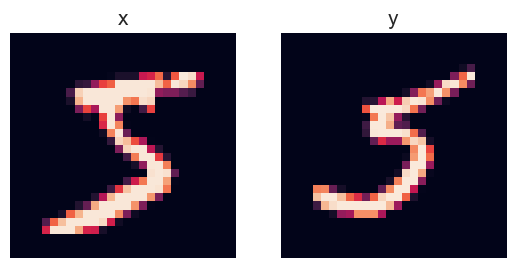

In [2]:
# Plot an example from the dataset
f, ax = plt.subplots(1,2)
ax[0].imshow(dataset[0]['x'][0])
ax[1].imshow(dataset[0]['y'][0])
ax[0].set_title('x', fontsize=15)
ax[1].set_title('y', fontsize=15)
ax[0].axis('off')
ax[1].axis('off');

Secondly we define a simple encoder architecture which maps the images of shape $[1 \times 28 \times 28]$ into a vector of shape [z_dim].

In [3]:
z_dim = 16

# Simple convolutional architecture with a flattening layer
encoder = nn.Sequential(
    nn.Conv2d(1, 16, 3),
    nn.ReLU(True),
    nn.Conv2d(16, 32, 5, stride=3),
    nn.ReLU(True),
    nn.Conv2d(32, 128, 8),
    nn.ReLU(True),
    nn.Flatten(),
    nn.Linear(128, z_dim)
)

Then, we can use the `TransformedMIEstimator` class to estimate mutual information between the encoded images using a mutual information estimation with provides valid gradient to update the encoder. Any discriminative estimator provides a valid lower-bound, which allows us to train the encoder together with the estimator.
Since the problem is symmetric in $x$ and $y$ we use the same encoder for both variables.

In the following example we use a simple 2-layer `SMILE` estimator with joint critic architecture and 8 negative samples for each pair of encoded $(f_x(x_i), f_y(y_i))$.

In [4]:
from torch_mist.estimators import TransformedMIEstimator, smile

transformed_estimator = TransformedMIEstimator(
    transforms={
        'x': encoder,
        'y': encoder,
    },
    base_estimator=smile(
        x_dim=z_dim,
        y_dim=z_dim,
        hidden_dims=[64, 32],
        neg_samples=32,
    )
)

transformed_estimator

TransformedMIEstimator(
  (base_estimator): SMILE(
    (ratio_estimator): JointCritic(
      (joint_net): DenseNN(
        (layers): ModuleList(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): Linear(in_features=64, out_features=32, bias=True)
          (2): Linear(in_features=32, out_features=1, bias=True)
        )
        (f): ReLU(inplace=True)
      )
    )
    (baseline): BatchLogMeanExp()
    (neg_samples): 32
  )
  (transforms): ModuleDict(
    (x->x): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 128, kernel_size=(8, 8), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=128, out_features=16, bias=True)
    )
    (y->y): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inpl

Lastly, we can train the estimator using the provided utilities and the `train_loder` for the custom dataset

In [5]:
from torch_mist.utils import train_mi_estimator

pd_log = train_mi_estimator(
    transformed_estimator,
    data=dataset,
    max_epochs=10,
    verbose=True,
    lr_annealing=False,
    batch_size=128
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/422 [00:00<?, ?it/s]

Since pairs of $x$ and $y$ are produced by considering data-points with the same label, we expect the mutual information value to approach $\ln 10$.

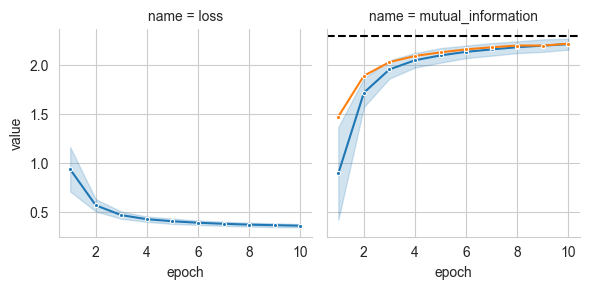

In [6]:
# Plot the estimated values of mutual information over time
grid = sns.FacetGrid(pd_log, col='name', hue='split')

grid.map(sns.lineplot, 'epoch', 'value', marker='.', errorbar='sd', label='estimate')
grid.axes[0,1].axhline(y=np.log(10), ls='--', color='k', label='True $I(x;y)$')


Other than mutual information estimation, this setup can be used to train encoder for dimensionality reduction.
In fact, the encoder is essentially trained following the `InfoMax` principle:
$$
\mathcal{L}^{InfoMax}(\theta) = - I(f_\theta(x),f_\theta(y))
$$
Popular choices involve the use of `InfoNCE`, or `JS` (known as *DeepInfoMax*) for information maximization, but all discriminative estimators are supported in practice.

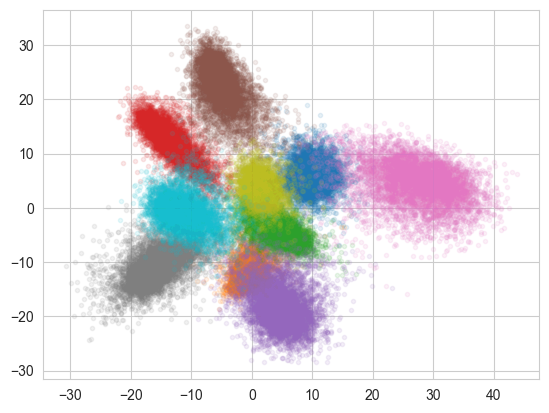

In [10]:
from sklearn.decomposition import PCA

# Compute the representation of all the images in the dataset with the trained encoder
zs = []

for data in DataLoader(dataset, batch_size=128):
    z = encoder(data['x'])
    zs.append(z)
zs = torch.cat(zs, 0).data.numpy()

# Project them to 2 dimensions using PCA
z_projected = PCA(2).fit_transform(zs)

# Plot them by label
for target in range(10):
    mask = dataset.mnist.targets==target
    plt.plot(z_projected[mask,0], z_projected[mask,1], '.', alpha=0.1)

## Maximally Informative Dimensions

Using `TransformedMIEstimator` as a starting point, we can design a dimensionality reduction technique, which is known as "Maximally Informative Dimensions" (`MID`). The main idea being that we are interested in projecting some data `x` onto a lower dimensional space (either linearly or not) in such a way that we maximally preserve information about some other quantity `y`.
The `torch_mist` package provides the `MID` dimensionality reduction method with a simple interface. For this example we will consider the [California Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing).



In [162]:
from sklearn.datasets import fetch_california_housing

# Get the dataset as a pandas DataFrame
california_housing = fetch_california_housing(as_frame=True)
dataframe = california_housing['data']
features = list(dataframe.columns)
print(f"Features: {features}")
dataframe['Price'] = california_housing['target']

# We a 8D vector of all the features as X and the house price as Y
X = dataframe[features].values
Y = dataframe['Price'].values

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


The `MID` projection provides the same interface as classic `sklearn.decomposition` methods such as `PCA`, while still providing the flexibility to specify parameters for estimation and projection.

In [182]:
from torch_mist.decomposition import MID
from sklearn.decomposition import PCA

projections = {
    'PCA': PCA(2, whiten=True),
    'Non-Linear MID': MID(2, whiten=True),
    'Linear MID': MID(
        2, whiten=True, 
        proj_params={'hidden_dims': []}, # No hidden dimensions for the projection (Linear) 
        mi_estimator_params={'estimator_name': 'infonce'}
    ),
}

The `fit(X, Y)` method takes care of training the projection and mutual information estimators. Additional training parameters can be also specified

In [184]:
from torch.optim import AdamW

print('Fitting PCA')
projections['PCA'].fit(X)

print('Fitting Non-Linear MID')
projections['Non-Linear MID'].fit(X, Y)

print('Fitting Linear MID')
projections['Linear MID'].fit(
    X, Y, 
    early_stopping=True, patience=2, 
    optimizer_class=AdamW,
)

Fitting PCA
Fitting Non-Linear MID


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/291 [00:00<?, ?it/s]

Fitting Linear MID


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/291 [00:00<?, ?it/s]

Loosing patience: 2
Loosing patience: 2


In [185]:
for name, proj in projections.items():
    z = proj.transform(X)
    dataframe[f'{name}[1]'] = z[:,0]
    dataframe[f'{name}[2]'] = z[:,1]

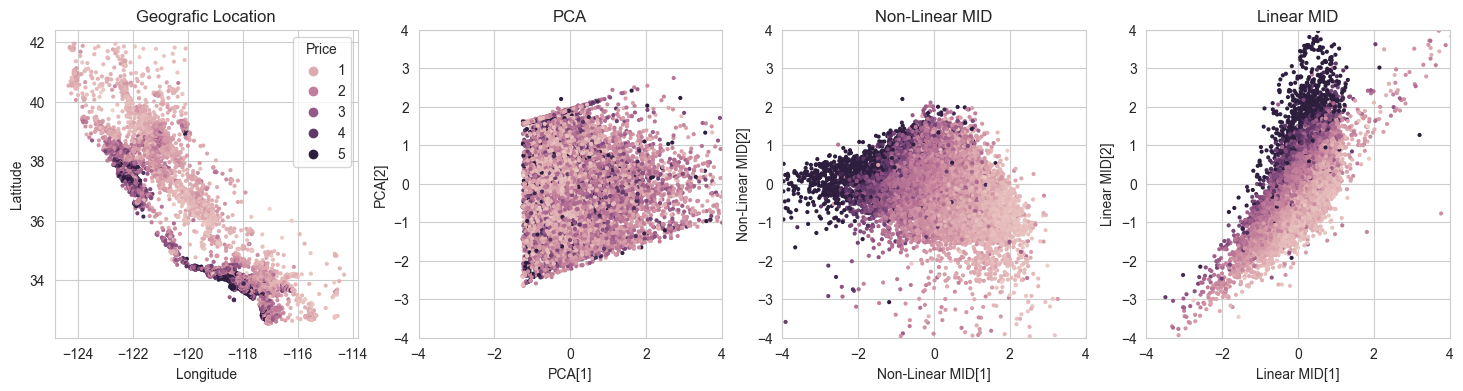

In [186]:
f, ax = plt.subplots(1,4, figsize=(18,4))

sns.scatterplot(dataframe, x='Longitude', y='Latitude', hue='Price', marker='.', ax=ax[0], linewidth=0)
ax[0].set_title("Geografic Location")

for i, name in enumerate(projections):
    sns.scatterplot(dataframe, x=f'{name}[1]', y=f'{name}[2]', hue='Price', marker='.', ax=ax[i+1], linewidth=0, legend=False)
    ax[i+1].set_title(name)
    ax[i+1].set_xlim(-4,4)
    ax[i+1].set_ylim(-4,4)


The training log is easily accessible with the `train_log` attribute after calling the `fit()` method

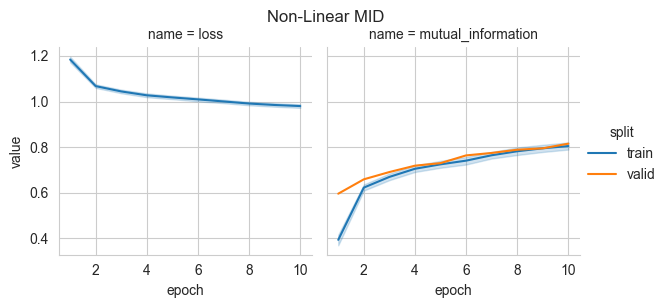

In [189]:
grid = sns.FacetGrid(projections['Non-Linear MID'].train_log, col='name', hue='split')
grid.map(sns.lineplot, 'epoch', 'value')
grid.add_legend()
grid.fig.suptitle('Non-Linear MID', y=1.01);